## This notebook can be used to rank a list of nodes from a category that connect to an entity such as a gene. 
#### Example 1: Identify drugs that has been approved or in-clinical-trial or in-test-for ovarian cancer


In [67]:
from TCT import node_normalizer
from TCT import name_resolver
from TCT import translator_metakg
from TCT import translator_kpinfo
from TCT import translator_query
from TCT import TCT

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import requests
import json
import pandas as pd
import  seaborn as sns
import networkx as nx
import numpy as np
import ipycytoscape
import yaml

In [68]:
Translator_KP_info,APInames= translator_kpinfo.get_translator_kp_info()
print(len(Translator_KP_info))
    # Step 2: Get metaKG and all predicates from Translator APIs through the SmartAPI system
metaKG = translator_metakg.get_KP_metadata(APInames) 
print(metaKG.shape)
    # Add metaKG from Plover API based KG resources
APInames,metaKG = translator_metakg.add_plover_API(APInames, metaKG)
print(metaKG.shape)
    # Step 3: list metaKG information
All_predicates = list(set(metaKG['Predicate']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))
API_withMetaKG = list(set(metaKG['API']))

    # generate a dictionary of API and its predicates
API_predicates = {}
for api in API_withMetaKG:
    API_predicates[api] = list(set(metaKG[metaKG['API'] == api]['Predicate']))



53
(10580, 5)
(22129, 5)


In [ ]:
def Neiborhood_finder(input_node, node2_categories, APInames, metaKG, API_predicates, input_node_category = []):
    """
    This function is used to find the neighborhood of a given input node with intermediate categories.
    
    --------------
    Parameters:
    input_node (str): The input node, can be a gene name, protein name, or any other identifier.
    node2_categories (list): A list of intermediate categories to be used in the neighborhood finding process.
    APInames (dict): A dictionary containing the names of the APIs to be used.
    metaKG (DataFrame): The metadata knowledge graph containing information about the APIs and their predicates.
    API_predicates (dict): A dictionary containing the predicates for each API.
    input_node_category (list): Optional. A list of categories for the input node. If empty, it will be derived from the input node's types.
    
    --------------
    Returns:
    input_node_id (str): The curie id of the input node.
    result (dict): The result of the query for the input node.
    result_parsed (DataFrame): The parsed results for the input node.
    result_ranked_by_primary_infores (DataFrame): The ranked results based on primary infores.
    
    --------------
    Example:
    >>> input_node_id, result, result_parsed, result_ranked_by_primary_infores1 = Neiborhood_finder('Ovarian cancer',
                                                                                            node2_categories = ['biolink:SmallMolecule', 'biolink:Drug', 'biolink:ChemicalEntity'],
                                                                                            APInames = APInames,
                                                                                            metaKG = metaKG,
                                                                                            API_predicates = API_predicates)   
    --------------
    
    """
    from TCT import name_resolver
    from TCT import translator_metakg
    from TCT import translator_kpinfo
    from TCT import translator_query

    # Step 1: Resolve the input node to get its curie id and categories
    input_node_info = name_resolver.lookup(input_node)
    input_node_id = input_node_info.curie
    print(input_node_id)
    
    if len(input_node_category) == 0:
        input_node_category = input_node_info.types 
    else:
        input_node_category = list(set(input_node_category).intersection(set(input_node_info.types)))
        if len(input_node_category) == 0:
            input_node_category = input_node_info.types

    # Step 2: Select predicates and APIs based on the intermediate categories
    sele_predicates, sele_APIs, API_URLs = TCT.sele_predicates_API(input_node_category,
                                                                node2_categories,
                                                                metaKG, APInames)

    # Step 3: Format the query JSON for the input node
    query_json = TCT.format_query_json([input_node_id], [], 
                                   [input_node_category], 
                                   node2_categories, 
                                   sele_predicates)

    # Step 4: Query the APIs in parallel
    result = translator_query.parallel_api_query(query_json=query_json, 
                             select_APIs= sele_APIs, 
                             APInames=APInames,
                             API_predicates=API_predicates,
                             max_workers=len(sele_APIs))
    result_parsed = TCT.parse_KG(result)
        # Step 7: Ranking the results. This ranking method is based on the number of unique
        # primary infores. It can only be used to rank the results with one defined node.
    result_ranked_by_primary_infores1 = TCT.rank_by_primary_infores(result_parsed, input_node_id)   # input_node1_id is the curie id of the
    return input_node_id, result, result_parsed, result_ranked_by_primary_infores1

In [36]:
# Find everything that is connected to a specific node

In [72]:
input_node_id, result, result_parsed, result_ranked_by_primary_infores1 = Neiborhood_finder('Ovarian cancer',
                                                                                            node2_categories = ['biolink:SmallMolecule', 'biolink:Drug', 'biolink:ChemicalEntity'],
                                                                                            APInames = APInames,
                                                                                            metaKG = metaKG,
                                                                                            API_predicates = API_predicates)     

MONDO:0008170
'MolePro' generated an exception: argument of type 'NoneType' is not iterable
'COHD TRAPI' generated an exception: argument of type 'NoneType' is not iterable
'imProving Agent for TRAPI 1.5' generated an exception: argument of type 'NoneType' is not iterable
'SPOKE KP for TRAPI 1.5' generated an exception: argument of type 'NoneType' is not iterable
'Automat-ehr-may-treat-kp(Trapi v1.5.0)' generated an exception: argument of type 'NoneType' is not iterable
'Multiomics KP - TRAPI 1.5.0' generated an exception: argument of type 'NoneType' is not iterable
'Microbiome KP - TRAPI 1.5.0' generated an exception: argument of type 'NoneType' is not iterable
'Automat-ehr-clinical-connections-kp(Trapi v1.5.0)' generated an exception: argument of type 'NoneType' is not iterable
'Automat-ubergraph(Trapi v1.5.0)' generated an exception: argument of type 'NoneType' is not iterable
'Automat-reactome(Trapi v1.5.0)' generated an exception: argument of type 'NoneType' is not iterable
Automa

In [73]:
result_ranked_by_primary_infores

,output_node,Name,Num_of_primary_infores,type_of_nodes,unique_predicates
6,CHEBI:176844,Niraparib,4,subject,"[biolink:treats, biolink:treats, biolink:treat..."
0,CHEBI:134689,Rucaparib,3,subject,"[biolink:treats, biolink:treats, biolink:in_cl..."
1,CHEBI:63632,Topotecan,3,subject,"[biolink:treats, biolink:treats, biolink:in_cl..."
3,CHEBI:175901,Gemcitabine,3,subject,"[biolink:treats, biolink:treats, biolink:in_cl..."
4,CHEBI:83766,Olaparib,3,subject,"[biolink:treats, biolink:treats, biolink:in_cl..."
...,...,...,...,...,...
161,UNII:RD2I59M9FC,PRALUZATAMAB RAVTANSINE,1,subject,[biolink:in_clinical_trials_for]
160,CHEBI:4031,Cyclosporine,1,subject,[biolink:in_clinical_trials_for]
159,UNII:YR3G369F5A,UNII:YR3G369F5A,1,subject,[biolink:in_clinical_trials_for]
158,UNII:SP24YIT5YZ,CDX-301,1,subject,[biolink:in_clinical_trials_for]


NodeNorm does not know about these identifiers: UNII:JDS6958QAG,UNII:Y8DGL9885E,UNII:4XTQ10247Y,UNII:S4MK9TOL0D,UNII:W2ZU1RY8B0,UNII:RXG7T6RB8K,UNII:17K7SN702N,UNII:RP9RQ0SOM8,UNII:BPG11IF0HW,UNII:HT3R7C012Q,UNII:8617Z5FMF6,UNII:NP6CFH3G8H,UNII:IZR558KO53,UNII:YR3G369F5A
[Text(0.5, 0, 'Niraparib'), Text(2.5, 0, 'Topotecan'), Text(4.5, 0, 'Olaparib'), Text(6.5, 0, 'Melphalan'), Text(8.5, 0, 'Cisplatin'), Text(10.5, 0, 'Bevacizumab'), Text(12.5, 0, 'Busulfan'), Text(14.5, 0, 'DUOCARMAZINE'), Text(16.5, 0, 'Anastrozole'), Text(18.5, 0, 'TETANUS TOXOID HELPER PEPTIDE'), Text(20.5, 0, 'Neratinib'), Text(22.5, 0, 'AZD4547'), Text(24.5, 0, 'Tinostamustine'), Text(26.5, 0, 'Fenretinide'), Text(28.5, 0, 'Sunitinib'), Text(30.5, 0, 'Pimasertib'), Text(32.5, 0, 'Toremifene'), Text(34.5, 0, 'Bortezomib'), Text(36.5, 0, 'motesanib diphosphate'), Text(38.5, 0, 'Interferon gamma-1b'), Text(40.5, 0, 'Dostarlimab'), Text(42.5, 0, 'FOLLICLE-STIMULATING HORMONE RECEPTOR'), Text(44.5, 0, 'Cabozantinib'), 

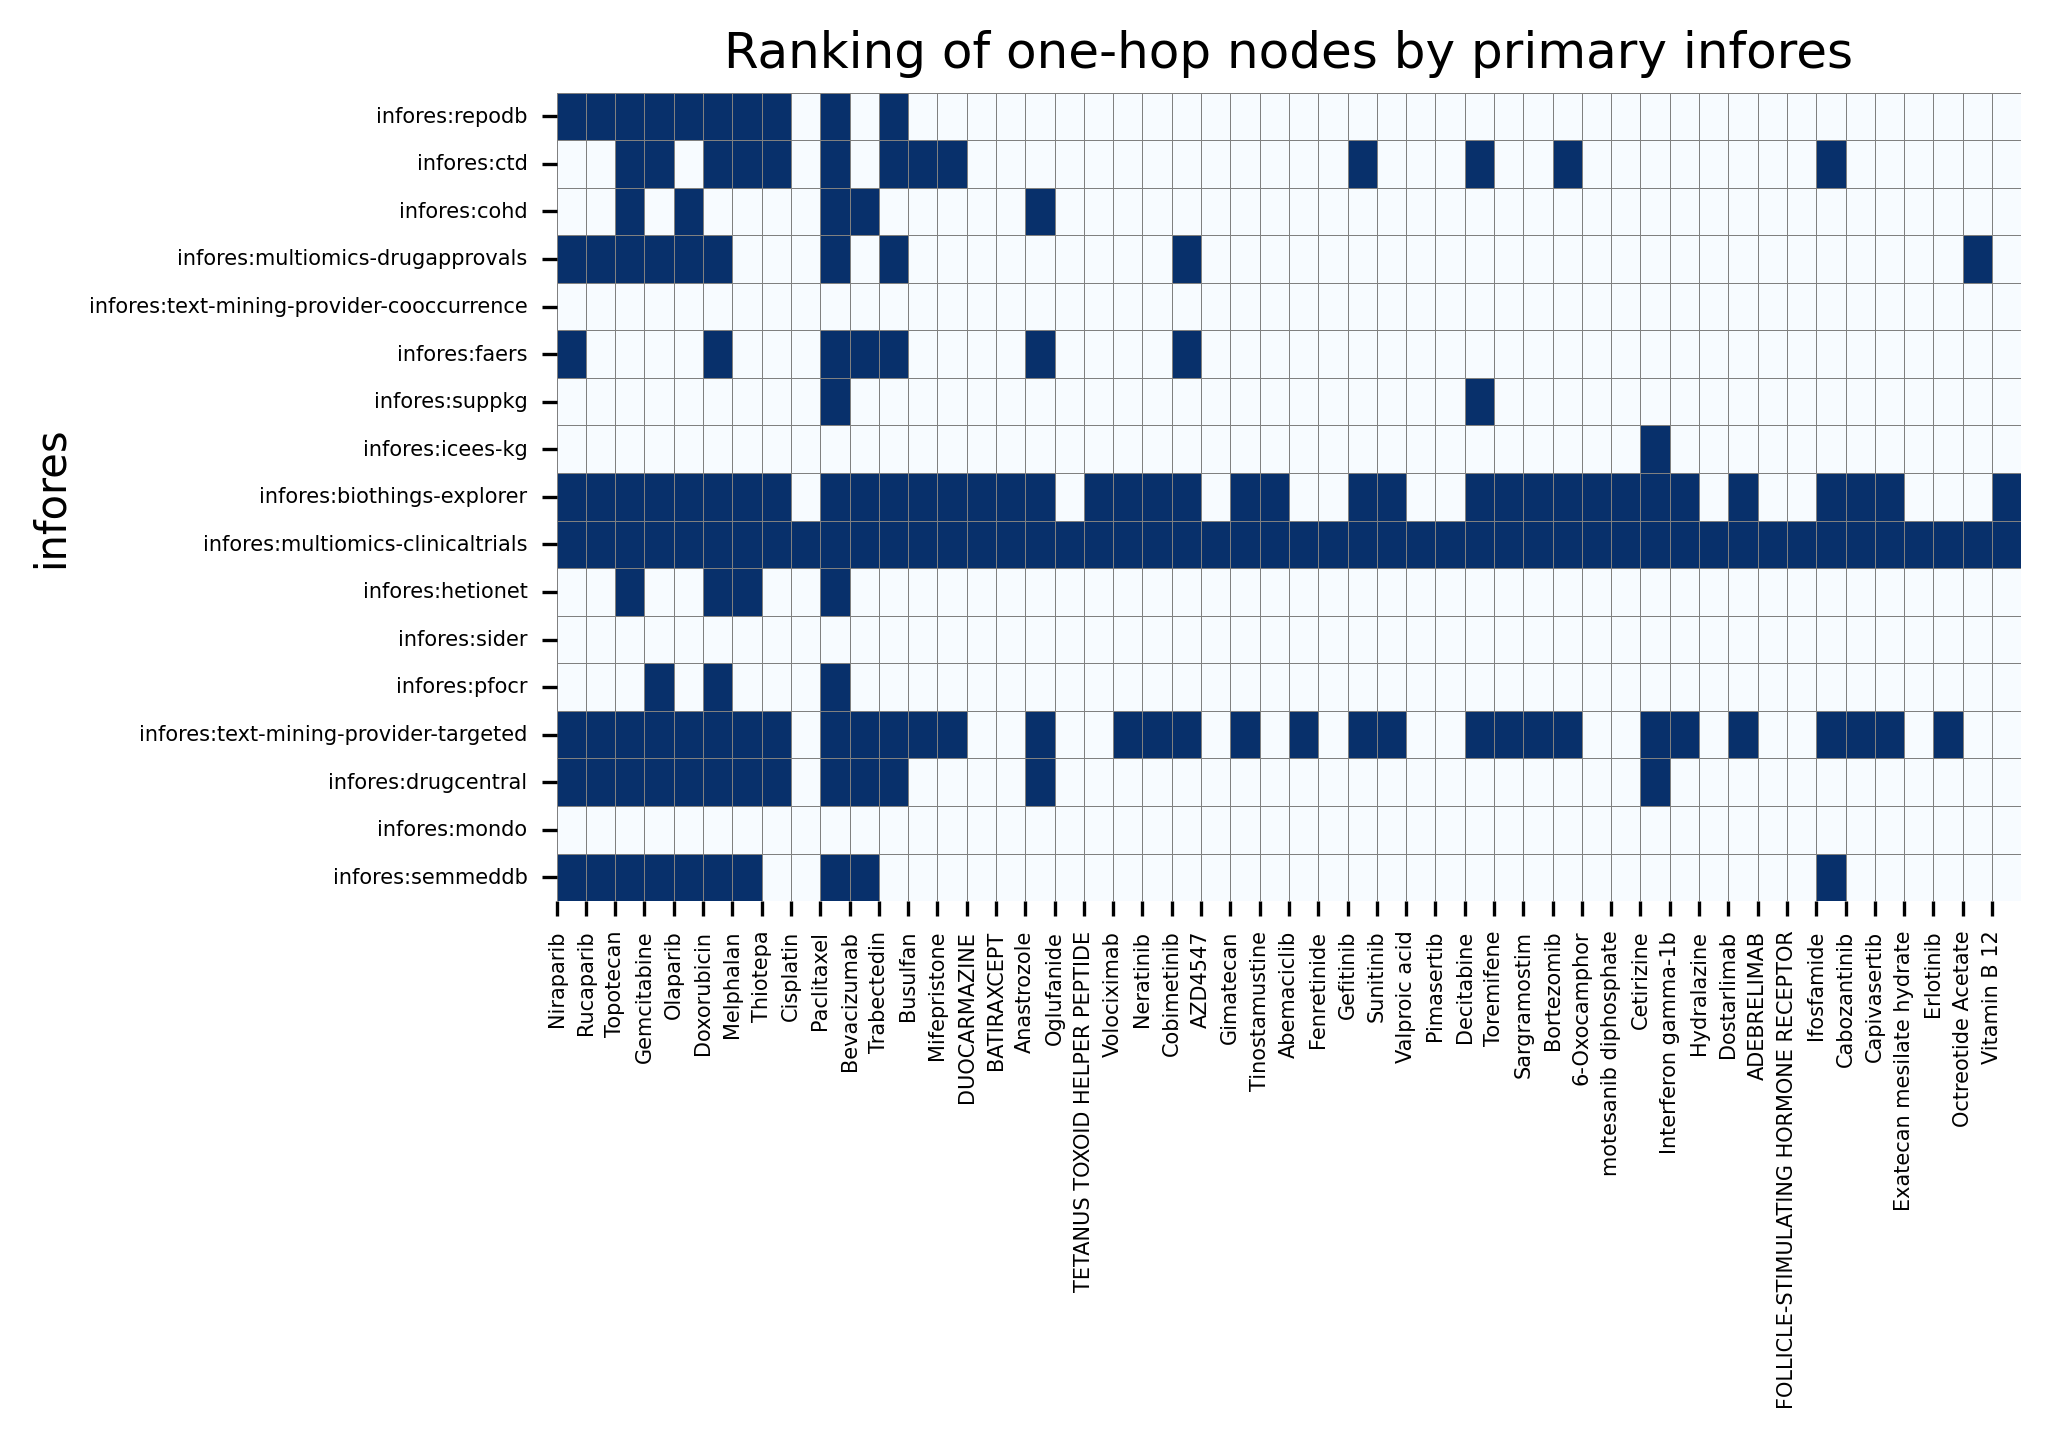

[Text(0.5, 0, 'Niraparib'), Text(2.5, 0, 'Topotecan'), Text(4.5, 0, 'Olaparib'), Text(6.5, 0, 'Melphalan'), Text(8.5, 0, 'Cisplatin'), Text(10.5, 0, 'Bevacizumab'), Text(12.5, 0, 'Busulfan'), Text(14.5, 0, 'DUOCARMAZINE'), Text(16.5, 0, 'Anastrozole'), Text(18.5, 0, 'TETANUS TOXOID HELPER PEPTIDE'), Text(20.5, 0, 'Neratinib'), Text(22.5, 0, 'AZD4547'), Text(24.5, 0, 'Tinostamustine'), Text(26.5, 0, 'Fenretinide'), Text(28.5, 0, 'Sunitinib'), Text(30.5, 0, 'Pimasertib'), Text(32.5, 0, 'Toremifene'), Text(34.5, 0, 'Bortezomib'), Text(36.5, 0, 'motesanib diphosphate'), Text(38.5, 0, 'Interferon gamma-1b'), Text(40.5, 0, 'Dostarlimab'), Text(42.5, 0, 'FOLLICLE-STIMULATING HORMONE RECEPTOR'), Text(44.5, 0, 'Cabozantinib'), Text(46.5, 0, 'Exatecan mesilate hydrate'), Text(48.5, 0, 'Octreotide Acetate')]


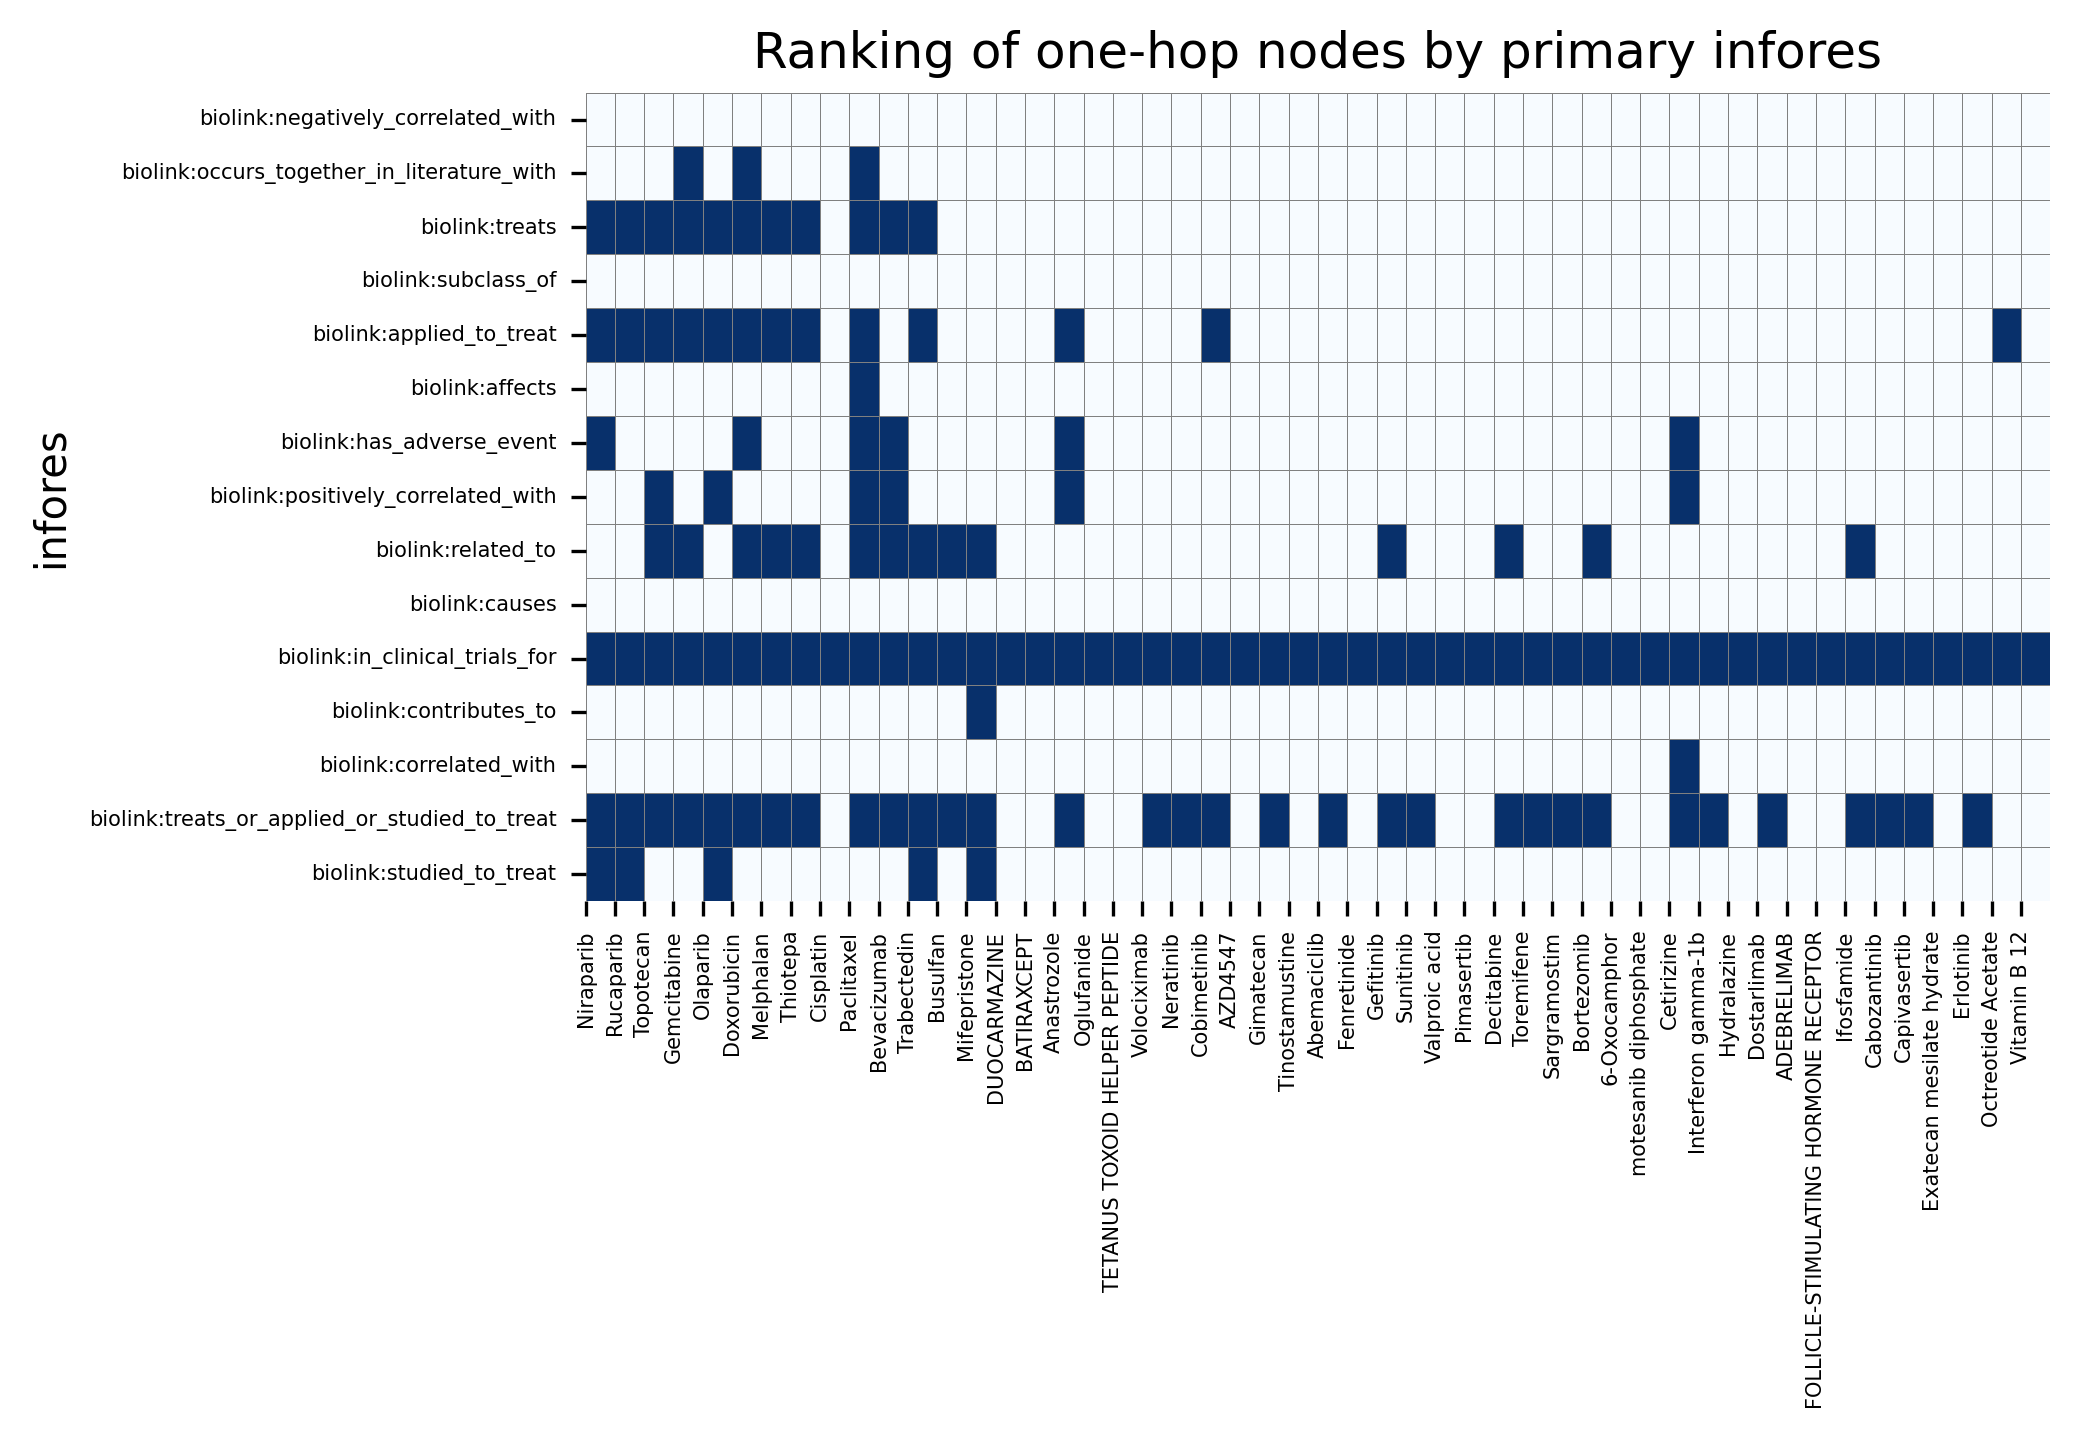

,Niraparib,Rucaparib,Topotecan,Gemcitabine,Olaparib,Doxorubicin,Melphalan,Thiotepa,Cisplatin,Paclitaxel,...,EFBEMALENOGRASTIM ALFA,Thalidomide,Tanespimycin,Metformin,FIANLIMAB,PRALUZATAMAB RAVTANSINE,Cyclosporine,UNII:YR3G369F5A,CDX-301,DT-2216
biolink:negatively_correlated_with,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:occurs_together_in_literature_with,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
biolink:treats,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
biolink:subclass_of,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:applied_to_treat,1,1,1,1,1,1,1,1,0,1,...,0,1,0,0,0,0,0,0,0,0
biolink:affects,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
biolink:has_adverse_event,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
biolink:positively_correlated_with,0,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
biolink:related_to,0,0,1,1,0,1,1,1,0,1,...,0,1,0,0,0,0,1,0,0,0
biolink:causes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, 
                                num_of_nodes = 50, input_query = input_node1_id, 
                                fontsize = 5)

In [45]:
# End of the example
